In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from patsy import dmatrices
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.stats.diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor

from research_utils.database.database import Database
from research_utils.analytics.beta_regression import Beta
from research_utils.analytics.lda import TopicModel

In [2]:
database = Database()

In [3]:
sql = """
SELECT a.package_id, a.package, a.organization,
	   a.duration_median, a.duration_mean, a.duration_variance, a.project_age,
	   b.crowd_pct, b.crowd, b.total as total_issues,
	   c.gini_coefficient, c.avg_clustering, c.avg_min_path,
	   d.total_contributors, e.diversity_10, e.diversity_25, e.diversity_50, e.diversity_100
FROM(
	SELECT package_id, package, organization,
		   PERCENTILE_DISC(0.5) WITHIN GROUP (ORDER BY duration) AS duration_median,
		   AVG(duration) AS duration_mean,
		   VARIANCE(duration) AS duration_variance,
		   EXTRACT(DAY FROM NOW() - MIN(created_at)) AS project_age
	FROM(
		SELECT package_id, organization, package, created_at,
			   EXTRACT(DAY FROM closed_at - created_at) as duration
               FROM open_source.issues
               WHERE closed_at IS NOT NULL AND pull_request IS FALSE
               AND created_at < '2019-01-01'
                AND ('bug' = ANY(lower(labels::text)::text[])
                OR 'feature' = ANY(lower(labels::text)::text[])
            OR 'feature request' = ANY(lower(labels::text)::text[])
            OR 'change' = ANY(lower(labels::text)::text[])
            OR 'suggestion' = ANY(lower(labels::text)::text[])
            OR 'enhancement' = ANY(lower(labels::text)::text[]))
		
	) z
	GROUP BY package_id, organization, package
) a
INNER JOIN open_source.crowd_percentage b
ON a.package_id = b.package_id
INNER JOIN (
	SELECT organization, package, gini_coefficient, avg_clustering, avg_min_path, crowd_pct
	FROM open_source.stakeholder_networks
) c
ON (a.package = c.package AND a.organization = c.organization)
INNER JOIN (
	SELECT COUNT(DISTINCT user_id) as total_contributors, package_id
	FROM open_source.issue_contributors
    WHERE commit_pct > 0
	GROUP BY package_id
) d
ON a.package_id = d.package_id
INNER JOIN open_source.packages e
ON a.package_id = e.id
"""
data = pd.read_sql(sql, database.connection)

In [4]:
tm = TopicModel(25, load=True)

In [5]:
df = tm.load_topic_model_results()

In [6]:
df.head()

,issue_time,issue_id,title,body,organization,package,issue_number,all_content,topics
0,2018-05-03 11:33:46,319883485,"Help command line arguments (-h, --help) are i...",The help arguments implicitly defined by the a...,actor-framework,actor-framework,688,"Help command line arguments (-h, --help) are i...","[0.009083141572773457, 0.009083141572773457, 0..."
1,2015-02-24 20:11:09,58796753,Remove match expr,The main objective of this change is to make C...,actor-framework,actor-framework,242,Remove match expr The main objective of this c...,"[0.006975634954869747, 0.006975634954869747, 0..."
2,2014-12-18 16:09:28,52381894,Enable actor publishing at random high-level port,"With this patch, using 0 as port parameter to ...",actor-framework,actor-framework,218,Enable actor publishing at random high-level p...,"[0.008186651393771172, 0.008186651393771172, 0..."
3,2018-01-08 17:03:43,286813990,The udp basp autoconnection test has a leak,"According to asan, there is a leak in the unit...",actor-framework,actor-framework,647,The udp basp autoconnection test has a leak Ac...,"[0.010533114895224571, 0.3219645917415619, 0.0..."
4,2014-12-17 11:32:12,52229707,Topic/pullrequest,More tests for the jenkins PR builder.\n,actor-framework,actor-framework,216,Topic/pullrequest More tests for the jenkins P...,"[0.013114626519382, 0.013114626519382, 0.01311..."


In [7]:
for i in range(tm.num_topics):
    df['topic_{}'.format(i)] = [x[i] if x else np.nan for x in df['topics']]

In [8]:
all_topics = ['topic_{}'.format(i) for i in range(tm.num_topics-1)]

In [9]:
mean_topics = df.groupby(['organization', 'package']).mean()[all_topics]

In [10]:
all_data = mean_topics.merge(data, on=['package', 'organization'])

Text(0, 0.5, 'Document Diversity')

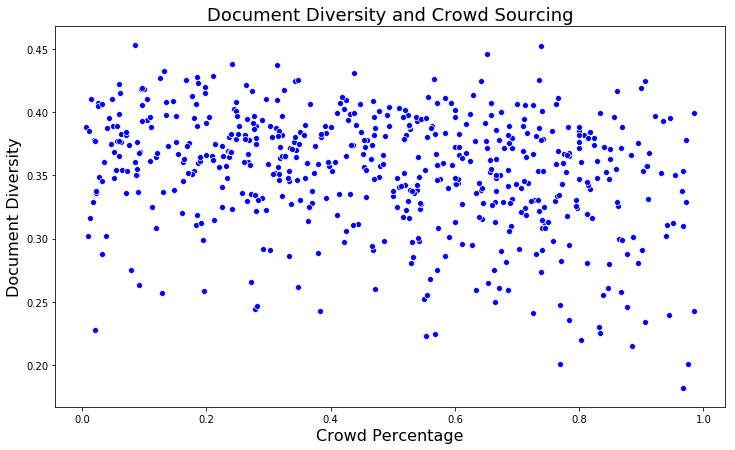

In [11]:
plt.figure(figsize=(12, 7))
sns.scatterplot(x=all_data['crowd_pct'], y=all_data['diversity_{}'.format(tm.num_topics)], color='blue')
plt.title('Document Diversity and Crowd Sourcing', fontsize=18)
plt.xlabel('Crowd Percentage', fontsize=16)
plt.ylabel('Document Diversity', fontsize=16)

In [12]:
all_data['crowd_pct_sq'] = np.sqrt(all_data['crowd_pct'])
all_data['crowd_pct_3'] = all_data['crowd_pct']**3
all_data['crowd_pct_2'] = all_data['crowd_pct']**2
all_data['log_crowd_pct'] = np.log(all_data['crowd_pct'])


In [13]:
y, X = dmatrices('diversity_{} ~ '
                 'crowd_pct +  '
                 'project_age + total_issues + total_contributors  + '
                 #'gini_coefficient + avg_clustering + avg_min_path '
                 ' + '.format(tm.num_topics) + ' + '.join(all_topics),
                 data=all_data, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
yhat = res.predict(X)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           diversity_25   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     10.92
Date:                Tue, 05 Nov 2019   Prob (F-statistic):           5.61e-37
Time:                        07:36:26   Log-Likelihood:                 1061.6
No. Observations:                 562   AIC:                            -2065.
Df Residuals:                     533   BIC:                            -1940.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.7776      0

Text(0, 0.5, 'Count')

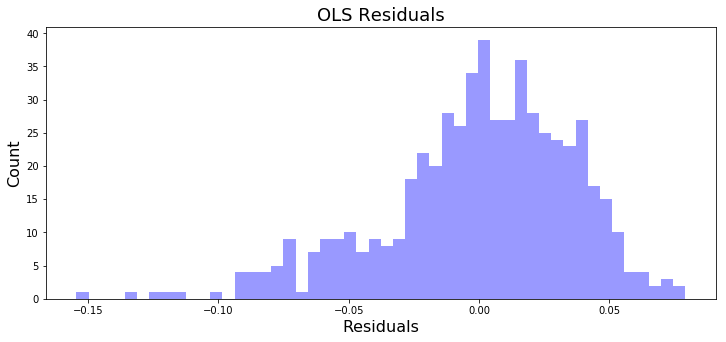

In [14]:
plt.figure(figsize=(12, 5))
sns.distplot(res.resid, kde=False, color='blue', bins=50)
plt.title('OLS Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Count', fontsize=16)

Text(0, 0.5, 'Document Diversity')

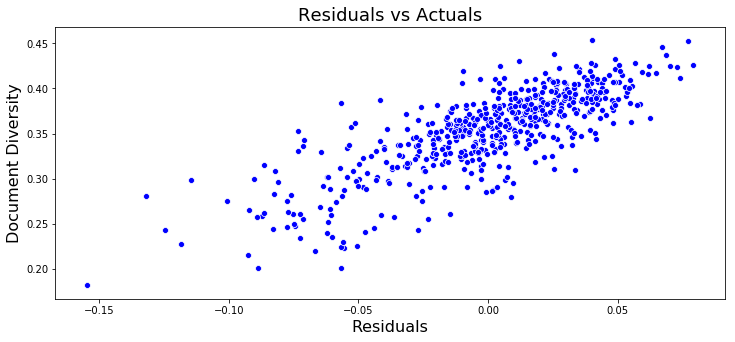

In [15]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x=res.resid, y=all_data['diversity_{}'.format(tm.num_topics)], color='blue')
plt.title('Residuals vs Actuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Document Diversity', fontsize=16)

In [16]:
mod = sm.OLS(y, X)
reg_res = mod.fit_regularized(alpha=.025)

In [17]:
yhat = reg_res.predict(X)
resid = np.array(y['diversity_25']) - yhat

Text(0, 0.5, 'Document Diversity')

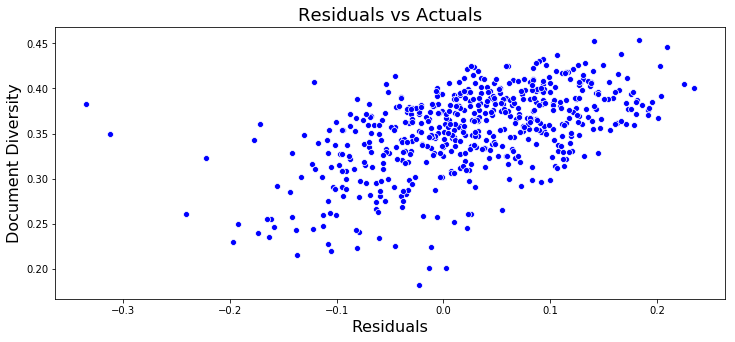

In [18]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x=resid, y=all_data['diversity_{}'.format(tm.num_topics)], color='blue')
plt.title('Residuals vs Actuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Document Diversity', fontsize=16)

Text(0, 0.5, 'Count')

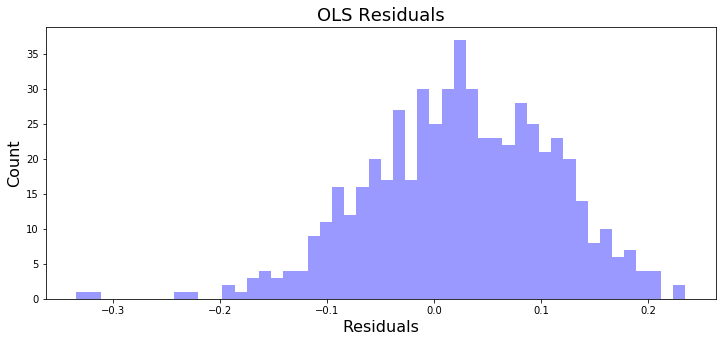

In [19]:
plt.figure(figsize=(12, 5))
sns.distplot(resid, kde=False, color='blue', bins=50)
plt.title('OLS Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Count', fontsize=16)